In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

SEED = 383561
np.random.seed(SEED) # from random.org, for reproducibility


/home/benjamin/miniconda3/envs/tensorflow/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# The Model 

In [2]:
import theano.tensor as tt
from pymc3.distributions.dist_math import gammaln, bound, factln

class DirichletMultinomial(pm.Discrete):
    def __init__(self, n, a, *args, **kwargs):
        super(DirichletMultinomial, self).__init__(*args, **kwargs)

        self.K = tt.as_tensor_variable(a.shape[-1])
        self.n = tt.as_tensor_variable(n[:, np.newaxis])

        if a.ndim == 1:
            self.alphas = tt.as_tensor_variable(a[np.newaxis, :])  # alphas[1, #classes]
        else:
            self.alphas = tt.as_tensor_variable(a)  # alphas[#samples, #classes]

        self.A = self.alphas.sum(axis=-1, keepdims=True)  # A[#samples]
        self.mean = self.n * (self.alphas / self.A)

        self.mode = tt.cast(pm.math.tround(self.mean), 'int32')

    def logp(self, value):
        printing = False
        k = self.K
        a = self.alphas
        A = self.A
        n = self.n
        res = bound(tt.squeeze(factln(n) + gammaln(A) - gammaln(A + n) +
                               tt.sum(gammaln(a + value) - gammaln(a) - factln(value), keepdims=True, axis=-1)),
                    tt.all(value >= 0),
                    tt.all(tt.eq(tt.sum(value, axis=-1, keepdims=True), n)),
                    tt.all(a > 0),
                    k > 1,
                    tt.all(tt.ge(n, 0)),
                    broadcast_conditions=False
                    )
        return res

In [3]:
def generate_spike_and_slab_model(n_total, X, data):
    n,k = X.shape
    m = data.shape[1]
    
    with pm.Model() as spike_and_slab_non_centered:
        
        #random effect
        packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                     eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(m, packed_L)

        #intercept
        sigma_alpha = pm.HalfCauchy("sigma_alpha", 5)
        #mu_alpha = pm.Normal("mu_alpha", mu=0, sd=100**2)
        alpha_offset = pm.Normal("alpha_offset", 0,1, shape=m)
        alpha = pm.Deterministic("alpha", 0. + alpha_offset*sigma_alpha)

        #fixed effect
        omega = pm.Beta("omega", 1, 1)
        pi = pm.Bernoulli("pi", omega, shape=(k,m))


        sigma_beta = pm.HalfCauchy("sigma_beta", 5)
        #mu_beta = pm.Normal("mu_beta", mu=0, sd=100**2)
        beta_offset = pm.Normal("beta_offset", 0, 1, shape=(k,m))
        beta_raw = pm.Deterministic("beta_raw", 0.+sigma_beta*beta_offset)


        log_gamma = pm.MvNormal("log_gamma", alpha + pm.math.dot(X, pi*beta_raw), chol=L, shape=(n,m))
        #log_gamma = alpha + pm.math.dot(X, pi*beta_raw) + V
        F1 = DirichletMultinomial('likelihood', n_total, 
                                  pm.math.exp(log_gamma), 
                                  observed = data)
    return spike_and_slab_non_centered


def generate_spike_and_slab_model_concrete(n_total, X, data):
    n,k = X.shape
    m = data.shape[1]
    
    with pm.Model() as spike_and_slab_non_centered:
        
        #random effect
        packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                     eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(m, packed_L)

        #intercept
        sigma_alpha = pm.HalfCauchy("sigma_alpha", 5)
        mu_alpha = pm.Normal("mu_alpha", mu=0, sd=100**2)
        alpha_offset = pm.Normal("alpha_offset", 0,1, shape=m)
        alpha = pm.Deterministic("alpha", mu_alpha + alpha_offset*sigma_alpha)

        #fixed effect
        #shape=(k,m)
        omega = pm.Beta("omega", 1, 1)
        pi = pm.Bernoulli("pi", omega, shape=(k,m))


        sigma_beta = pm.HalfCauchy("sigma_beta", 5)
        mu_beta = pm.Normal("mu_beta", mu=0, sd=100**2)
        beta_offset = pm.Normal("beta_offset", 0, 1, shape=(k,m))
        beta_raw = pm.Deterministic("beta_raw", mu_beta+sigma_beta*beta_offset)


        gamma = pm.MvNormal("log_gamma", alpha + pm.math.dot(X, pi*beta_raw), chol=L, shape=(n,m))
        #log_gamma = alpha + pm.math.dot(X, pi*beta_raw) + V
        F1 = pm.Multinomial('likelihood', n_total, 
                                   tt.nnet.softmax(gamma),
                                  observed = data)
    return spike_and_slab_non_centered


def generate_regression_model(n_total, X, data):
    n,k = X.shape
    m = data.shape[1]
    
    with pm.Model() as spike_and_slab_non_centered:
        
        #random effect
        packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                     eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(m, packed_L)

        #intercept
        sigma_alpha = pm.HalfCauchy("sigma_alpha", 5)
        alpha_offset = pm.Normal("alpha_offset", 0,1, shape=m)
        alpha = pm.Deterministic("alpha", alpha_offset*sigma_alpha)


        sigma_beta = pm.HalfCauchy("sigma_beta", 5)
        beta_offset = pm.Normal("beta_offset", 0, 1, shape=(k,m))
        beta_raw = pm.Deterministic("beta_raw", sigma_beta*beta_offset)

        log_gamma = pm.MvNormal("log_gamma", alpha + pm.math.dot(X, beta_raw), chol=L, shape=(n,m))
        #log_gamma = alpha + pm.math.dot(X, pi*beta_raw) + V
        F1 = DirichletMultinomial('likelihood', n_total, 
                                  pm.math.exp(log_gamma), 
                                  observed = data)
    return spike_and_slab_non_centered



def generate_simple_regression_model(n_total, X, data):
    n,k = X.shape
    m = data.shape[1]
    
    with pm.Model() as spike_and_slab_non_centered:
        

        #intercept
        sigma_alpha = pm.HalfCauchy("sigma_alpha", 5,shape=m)
        alpha = pm.MvNormal("alpha", mu=np.zeros(m), cov=sigma_alpha*np.eye(m), shape=m)

        nu = pm.HalfCauchy("nu", 1, shape=k)
        sigma_beta = pm.HalfCauchy("sigma_beta", 5,shape=m)

        beta = pm.MatrixNormal("beta", mu=np.zeros((k,m)), 
                               rowcov=nu*np.eye(k),colcov=sigma_beta*np.eye(m), shape=(k,m))
        #beta_print = tt.printing.Print("beta")(beta)
        #print(beta_print.shape)
        log_gamma = alpha + pm.math.dot(X, beta)
        F1 = DirichletMultinomial('likelihood', n_total, 
                                  pm.math.exp(log_gamma), 
                                  observed = data)
    return spike_and_slab_non_centered


def generate_mixed_effect_regression_model(n_total, X, data):
    n,k = X.shape
    m = data.shape[1]
    
    with pm.Model() as spike_and_slab_non_centered:
        
        # random effect this now has a shared covariance structure across samples
        packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                     eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(m, packed_L)
        
        z = pm.MvNormal("z",np.zeros(m), chol=L, shape=(n,m))
        
        #intercept
        sigma_alpha = pm.HalfCauchy("sigma_alpha", 5,shape=m)
        alpha = pm.MvNormal("alpha", mu=np.zeros(m), cov=sigma_alpha*np.eye(m), shape=m)

        nu = pm.HalfCauchy("nu", 1, shape=k)
        sigma_beta = pm.HalfCauchy("sigma_beta", 5,shape=m)

        beta = pm.MatrixNormal("beta", mu=np.zeros((k,m)), 
                               rowcov=nu*np.eye(k),colcov=sigma_beta*np.eye(m), shape=(k,m))
        #beta_print = tt.printing.Print("beta")(beta)
        #print(beta_print.shape)
        log_gamma = alpha + pm.math.dot(X, beta) + z
        F1 = DirichletMultinomial('likelihood', n_total, 
                                  pm.math.exp(log_gamma), 
                                  observed = data)
    return spike_and_slab_non_centered

# Uncorrelated Simulation Study


In [19]:
#n = 20 # number of samples
#m = 10  # number of populations 
#k = 3  # number of covariats

#m_r = 5 number of effected populations
#k_r = 2 number of non-zero covariats
from pymc3.variational.callbacks import CheckParametersConvergence

def generate_data(n=10, m=2, k=2, m_r=1, k_r=1,rho=0.4):

    # Covaraits drawn from MvNormal(0, Cov) Cov_ij = p ^|i-j| , p=0.4
    #Tibshirani for correlated covariats Tibshirani (1996) 
    #X_cov =np.array([[rho**np.abs(i-j) for j in range(k)] for i in range(k)])
    X_cov = np.eye(k)
    X = np.random.multivariate_normal(np.zeros(k), cov=X_cov, size=n)
    print(X.shape)
    m_r_idx = np.random.choice(range(m), size=m_r, replace=False)
    k_r_idx = np.random.choice(range(k), size=k_r, replace=False)

    # slope and intercepts
    alphas = np.random.uniform(-1, 1, size=m)
    betas = np.zeros((k,m))

    for i in k_r_idx:
        for j in m_r_idx:
            #p = np.random.binomial(n=1, p= 0.5)
            betas[i,j] = 2. 
    
    xi = 0.01 #dispersion parameter
    gamma = np.exp(alphas + np.matmul(X, betas))
    #gamma_plus = gamma_raw.sum(axis=1)
    #gamma = (gamma_raw/gamma_plus[:, None]) *((1-xi)/xi)
    
    y = np.zeros((n, m))
    
    # sample total number of reads:
    n_total = np.random.randint(20000, 50000, size=n)
    
    for i in range(n):
        pi = np.random.dirichlet(gamma[i,:])
        y[i,:] = np.random.multinomial(n_total[i], pi)
    
    return n_total,X,y,m_r_idx, k_r_idx
    
    
def calc_statistics(beta_true, m_r_idx, k_r_idx):
    """
    calculates TPR and FTR AUC MCC etc.
    """
    
    
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)


    
def run_uncorrelated_simulation(N=1):
    n=30 
    m=3
    k=10 
    m_r=1 
    k_r=3
    
    
    for h in range(N):
        n_total, X_data,y_data, m_r_idx, k_r_idx = generate_data(n,m,k,m_r,k_r)
        #model = generate_regression_model(n_total, X_data, y_data)
        #model = generate_spike_and_slab_model(n_total, X_data, y_data)
        model = generate_simple_regression_model(n_total, X_data, y_data)
        #model = generate_mixed_effect_regression_model(n_total, X_data, y_data)
        
        
        #print(n_total)
        #print()
        #print(X_data)
        #print()
        #print(y_data)
        print(k_r_idx, m_r_idx)
        
        with model:
            #trace = pm.sample(chains=2)
            #trace = pm.fit(method='advi',  callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')]).sample(1000)
            trace = pm.fit(method='fullrank_advi').sample(1000)
            #trace = pm.find_MAP()
        return trace
    
trace = run_uncorrelated_simulation()




(30, 10)
[8 0 5] [2]


Average Loss = 590.95: 100%|██████████| 10000/10000 [35:13<00:00,  4.82it/s]
Finished [100%]: Average Loss = 590.92


In [20]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,0.207287,0.310004,0.009877,-0.405620,0.793923
alpha__1,-0.173397,0.292066,0.009300,-0.727174,0.408856
alpha__2,-0.165090,0.285042,0.009271,-0.754583,0.355415
beta__0_0,-0.435354,0.307958,0.010262,-1.064417,0.121583
beta__0_1,-0.223063,0.242796,0.007912,-0.683963,0.260427
beta__0_2,0.983994,0.296540,0.009739,0.402812,1.575610
beta__1_0,0.113407,0.292324,0.009306,-0.449740,0.688592
beta__1_1,0.122998,0.298293,0.009638,-0.485484,0.680902
beta__1_2,0.455993,0.334834,0.010522,-0.205848,1.101562
beta__2_0,0.044306,0.247059,0.007384,-0.397915,0.555130


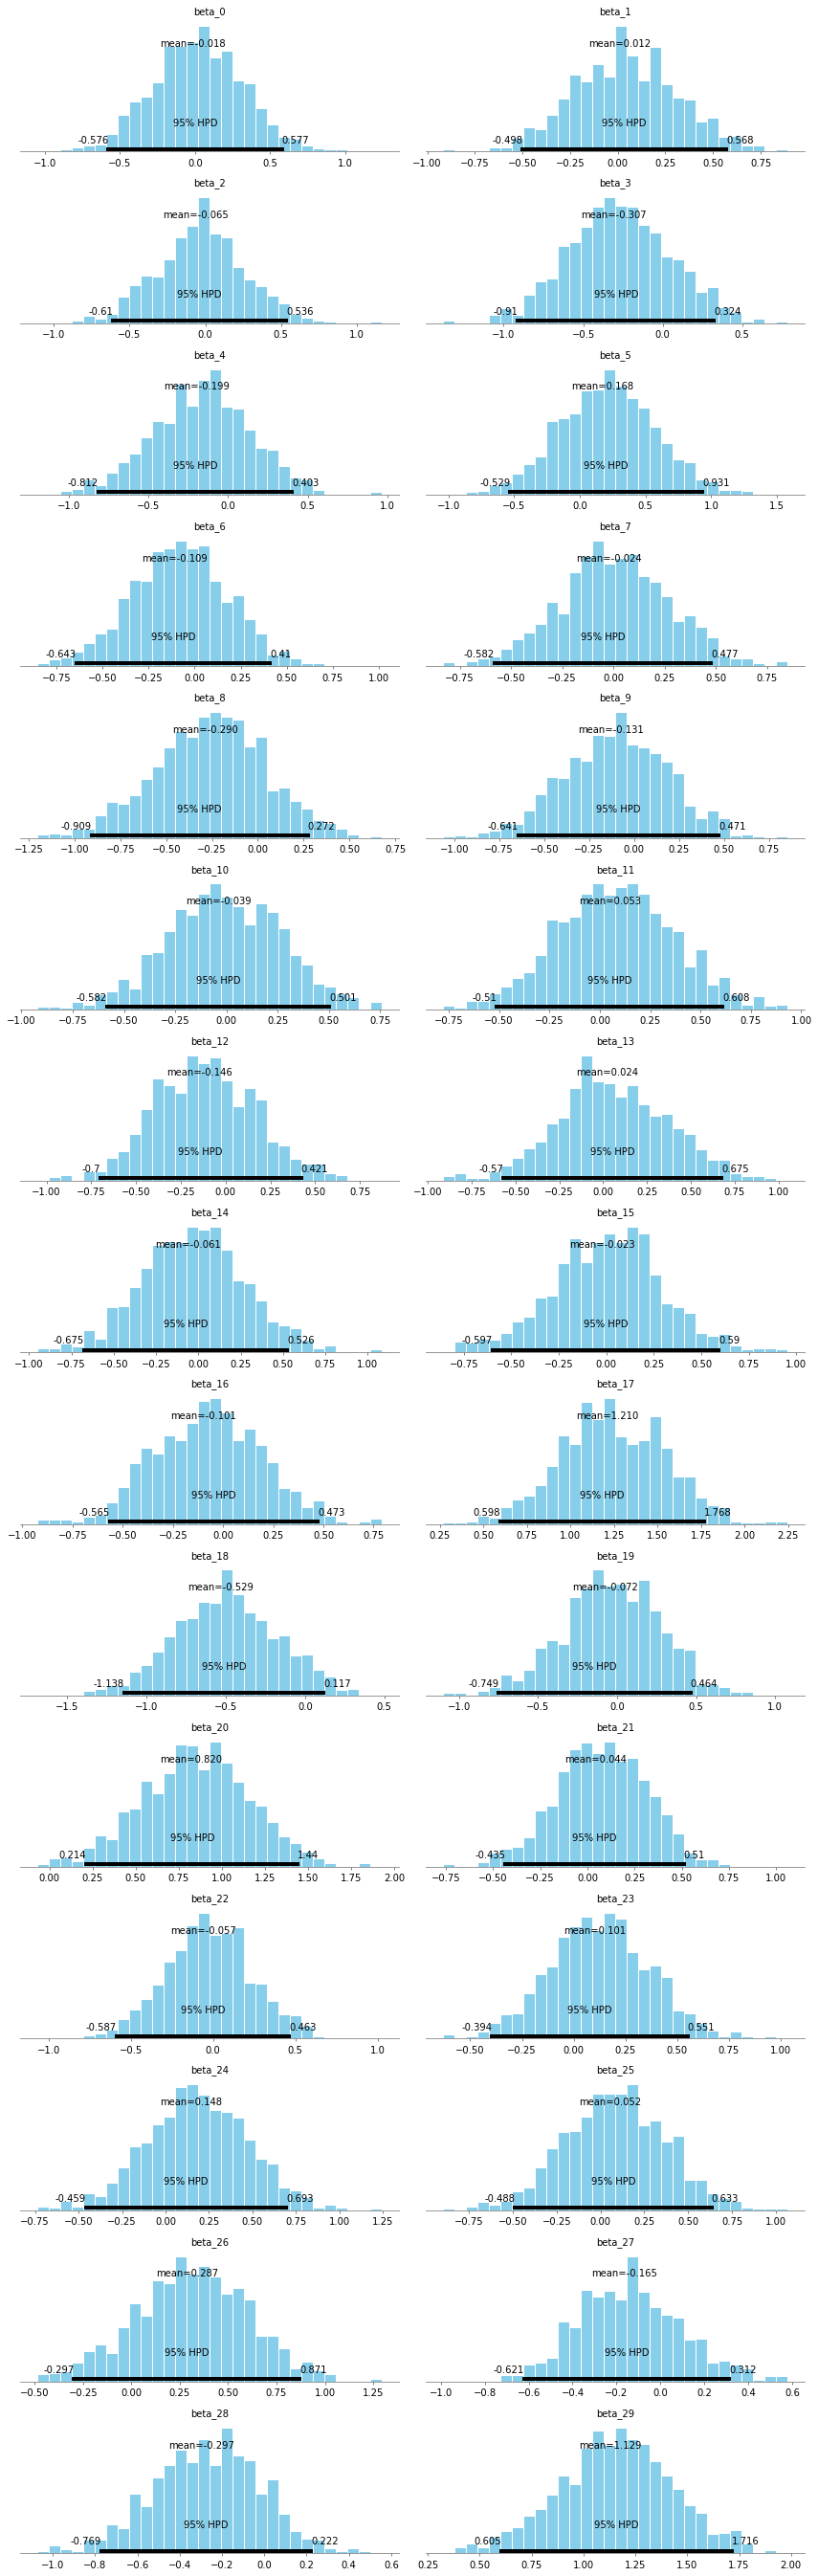

In [94]:
t = pm.posteriorplot.plot_posterior(trace, varnames=["beta"])

In [21]:
from scipy.stats import norm


for i in range(10):
    for j in range(3):
        print("Species=%i, Covariat=%i: P-val=%f3"%(i,j, norm.sf(abs((np.mean(trace.beta[:,i,j]) - 0.0)/np.std(trace.beta[:,i,j])))))

        

Species=0, Covariat=0: P-val=0.0787283
Species=0, Covariat=1: P-val=0.1791203
Species=0, Covariat=2: P-val=0.0004533
Species=1, Covariat=0: P-val=0.3490263
Species=1, Covariat=1: P-val=0.3400463
Species=1, Covariat=2: P-val=0.0866233
Species=2, Covariat=0: P-val=0.4288373
Species=2, Covariat=1: P-val=0.4651963
Species=2, Covariat=2: P-val=0.1360143
Species=3, Covariat=0: P-val=0.3464233
Species=3, Covariat=1: P-val=0.4758643
Species=3, Covariat=2: P-val=0.2836283
Species=4, Covariat=0: P-val=0.3804023
Species=4, Covariat=1: P-val=0.4380183
Species=4, Covariat=2: P-val=0.2795933
Species=5, Covariat=0: P-val=0.1652623
Species=5, Covariat=1: P-val=0.4308933
Species=5, Covariat=2: P-val=0.0026453
Species=6, Covariat=0: P-val=0.3940323
Species=6, Covariat=1: P-val=0.3054523
Species=6, Covariat=2: P-val=0.3814443
Species=7, Covariat=0: P-val=0.3397653
Species=7, Covariat=1: P-val=0.3182983
Species=7, Covariat=2: P-val=0.4581793
Species=8, Covariat=0: P-val=0.1277593
Species=8, Covariat=1: P-

In [ ]:
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()